In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


class CONFIG:
    """
    > General Options
    """

    # global seed
    seed = 42
    # the number of samples to use for testing purposes
    # if None, we use the full dataset
    samples_testing = None  # None
    # max rows to display for pandas dataframes
    display_max_rows = 100
    # name of the response variate we are trying to predict
    response_variate = "score"

    max_timeseries_length = 5000  # Maximum length that model can take.

    """
    > Preprocessing Options
    """
    # number of folds to split the data for CV
    num_folds = 5

    """
    > Modelling Options
    """
    # whether to use optuna tuning or not
    # if False, then we load in pretuned weights for the LGBM models
    use_optuna_tuning = True
    # size of the test set for optuna tuning
    # if use_optuna_tuning=True
    test_size_optuna = 0.3
    # number of estimators to use for the boosting model
    num_estimators = 10000
    # number of trials to use for optuna tuning
    # if use_optuna_tuning=True
    num_trials_optuna = 250
    # number of trials to use for early stopping
    num_trials_early_stopping = 250

    """
    > Post-Modelling Options
    """
    # number of most important features to display
    # for the feature importances plot
    num_features_to_display = 50

# Import Utility Script & Libraries

In [2]:
import gc
import os
import random
import re
import warnings
from collections import Counter
from typing import List

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import torch
from gensim.models import Word2Vec
from scipy.stats import kurtosis, skew
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from tqdm.autonotebook import tqdm
import category_encoders as ce

/home/rohit/Desktop/kaggle/virtualenvs/writing_quality/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(torch.__version__)

2.1.0+cu121


In [4]:
tqdm.pandas()

sns.set_style("whitegrid")

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", CONFIG.display_max_rows)
warnings.simplefilter("ignore")

random.seed(CONFIG.seed)

# Load Data

In [5]:
INPUT_DIR = "./data"

train_logs = pd.read_csv(f"{INPUT_DIR}/train_logs.csv")
train_scores = pd.read_csv(f"{INPUT_DIR}/train_scores.csv")
test_logs = pd.read_csv(f"{INPUT_DIR}/test_logs.csv")

In [6]:
df_train = train_logs.merge(train_scores, on="id", suffixes=(None, None))

## Subsample Data (If Specified)

In [7]:
# if CONFIG.samples_testing is not None:
#     ids = list(train_logs["id"].unique())
#     sample_ids = random.sample(ids, CONFIG.samples_testing)
#     train_logs = train_logs[train_logs["id"].isin(sample_ids)]

In [8]:
train_logs.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


### Timeseries representation part ####

In [9]:
activity_values = [
    "Input",
    "Remove/Cut",
    "Nonproduction",
    "Replace",
    "Paste",
    "Unidentified",
    "__NoActivity",
]
event_values = [
    "q",
    "Space",
    "Backspace",
    "Shift",
    "ArrowRight",
    "Leftclick",
    "ArrowLeft",
    ".",
    ",",
    "ArrowDown",
    "ArrowUp",
    "Enter",
    "CapsLock",
    "'",
    "Delete",
    "Unidentified",
    "Control",
    '"',
    "-",
    "?",
    ";",
    "=",
    "Tab",
    "/",
    "Rightclick",
    ":",
    "(",
    ")",
    "\\",
    "ContextMenu",
    "End",
    "!",
    "Meta",
    "Alt",
    "[",
    "c",
    "v",
    "NumLock",
    "Insert",
    "Home",
    "z",
    "AudioVolumeDown",
    "F2",
    "a",
    "x",
    "AudioVolumeUp",
    "$",
    ">",
    "]",
    "*",
    "%",
    "&",
    "Dead",
    "s",
    "Escape",
    "ModeChange",
    "F3",
    "<",
    "AudioVolumeMute",
    "F15",
    "+",
    "ScrollLock",
    "Process",
    "PageDown",
    "t",
    "i",
    "_",
    "{",
    "PageUp",
    "`",
    "0",
    "#",
    "1",
    "Middleclick",
    "5",
    "F12",
    "Unidentified",
    "__NoEvent",
]

In [10]:
### Categorical variables ####
def get_binary_encoders(activity_values,event_values):
    binary_encoders = {}

    # lb_activity = LabelBinarizer()
    lb_activity = ce.BinaryEncoder()
    lb_activity.fit(activity_values)

    # lb_event = LabelBinarizer()
    lb_event = ce.BinaryEncoder()
    lb_event.fit(event_values)

    binary_encoders["activity"] = lb_activity
    binary_encoders["down_event"] = lb_event
    binary_encoders["up_event"] = lb_event
    return binary_encoders

In [11]:
binary_encoders = get_binary_encoders(activity_values,event_values)

In [12]:
def replace_activity_and_event_values(df,activity_values,event_values):
    df['activity'] = df.activity.apply(lambda x: x if x in activity_values else 'Unidentified')
    df['down_event'] = df.down_event.apply(lambda x: x if x in activity_values else 'Unidentified')
    df['up_event'] = df.up_event.apply(lambda x: x if x in activity_values else 'Unidentified')


    return df
    

In [13]:
def make_seq_max_length_seq(seq, max_length, value_to_add):
    if len(seq) < max_length:
        to_add_seq = [value_to_add] * (max_length - len(seq))
        new_seq = seq + to_add_seq
    else:
        new_seq = seq[:max_length]
    return new_seq

In [14]:
def get_grouped_df(
    exploded_df: pd.DataFrame, grp_by_clms: List[str] = ["id"]
) -> pd.DataFrame:
    grpd_df = exploded_df.groupby(grp_by_clms, as_index=False).agg(
        lambda x: list(x),
    )
    grpd_df["num_events"] = grpd_df.apply(lambda x: len(x.event_id), axis=1)

    values_to_add = {
        "down_time": -1,
        "up_time": -1,
        "action_time": -1,
        "activity": "__NoActivity",
        "down_event": "__NoEvent",
        "up_event": "__NoEvent",
        # "text_change",
        "cursor_position": -1,
        "word_count": -1,
    }

    for clm in values_to_add.keys():
        grpd_df[clm] = grpd_df[clm].apply(
            lambda x: make_seq_max_length_seq(
                x, CONFIG.max_timeseries_length, values_to_add[clm]
            )
        )

    cat_clms = ['activity','down_event','up_event']
    for cat_clm in cat_clms:
        grpd_df[f"{cat_clm}_enc"] = grpd_df[cat_clm].apply(lambda x: binary_encoders[cat_clm].transform(x).values)

    return grpd_df

In [15]:
# train_grpd_df = get_grouped_df(train_logs)

In [16]:
# train_grpd_df.head()

In [17]:
# train_grpd_df.shape

In [18]:
class MultivariateTimeseriesDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, df, is_test=False):
        """
        Arguments:
        df: A grouped dataframe (sequences as list) and pre-processed to make each sequence of max sequence length
        is_test: Define whether it is a test set data loader.

        """
        self.df = df
        self.real_clms = [
            "down_time",
            "up_time",
            "action_time",
            "cursor_position",
            "word_count",
        ]

        self.cat_clms = [
            "activity_enc",
            "down_event_enc",
            "up_event_enc",
            # "text_change",
        ]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        row_tensors = []
        for clm in self.real_clms:
            tmp_tensor = torch.FloatTensor(row[clm]).reshape(-1, 1)
            row_tensors.append(tmp_tensor)

        for clm in self.cat_clms:
            tmp_tensor = torch.FloatTensor(row[clm])
            row_tensors.append(tmp_tensor)

        final_tensor = torch.cat(row_tensors, 1)
        final_tensor = torch.as_tensor(final_tensor, dtype=torch.float32)

        return final_tensor, row["id"]

In [19]:
# train_dataset = MultivariateTimeseriesDataset(train_grpd_df)
# train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False)
# dataloader_iterator = iter(train_dataloader)
# X,idx= next(dataloader_iterator)

In [20]:
# X.shape

In [21]:
# idx

In [22]:
hyper_params = {
    "encoder": {"num_layers": 1, "enable_nested_tensor": True},
    "encoder_layer": {"nhead": 1, "dim_feedforward": 64},
    "enc_projection_head": {
        "enc_projection_dim": 4096,
        "num_layers": 4,
        "out_features_each_layer": [512, 256, 128, 64],
        "dropout": 0.1,
    },
    "cal_feature_projection_head": {
        "num_layers": 2,
        "out_features_each_layer": [128, 128],
        "dropout": 0.1,
    },
    "regressor_head": {
        "num_layers": 4,
        "out_features_each_layer": [128, 128, 64, 64],
        "dropout": 0.1,
    },
    "calculated_clms_len": -1,
}

In [23]:
model_params = {}
model_params["seq_dim"] = 22
model_params["seq_length"] = CONFIG.max_timeseries_length
model_params["hyper_params"] = hyper_params
model_params["use_cal_features"] = False

In [24]:
class MultivariateTimeseriesRegression(torch.nn.Module):
    def __init__(self, seq_dim=0, seq_length=0, use_cal_features=True, hyper_params={}):
        super().__init__()

        self.seq_dim = seq_dim
        self.seq_length = seq_length
        self.use_cal_features = use_cal_features
        encoder_layer = torch.nn.TransformerEncoderLayer(
            d_model=seq_dim,
            nhead=hyper_params["encoder_layer"]["nhead"],
            dim_feedforward=hyper_params["encoder_layer"]["dim_feedforward"],
            batch_first=True,
        )
        self.encoder = torch.nn.TransformerEncoder(
            encoder_layer,
            hyper_params["encoder"]["num_layers"],
            enable_nested_tensor=hyper_params["encoder"]["enable_nested_tensor"],
        )

        # PRojection Head

        projection_input_dim = seq_dim * seq_length
        modules = torch.nn.ModuleList()
        modules.append(
            torch.nn.Sequential(
                torch.nn.Flatten(start_dim=1),
                torch.nn.Linear(
                    projection_input_dim,
                    hyper_params["enc_projection_head"]["enc_projection_dim"],
                ),
            )
        )
        current_dim = hyper_params["enc_projection_head"]["enc_projection_dim"]
        for i in range(hyper_params["enc_projection_head"]["num_layers"]):
            temp_block = torch.nn.Sequential(
                torch.nn.Linear(
                    current_dim,
                    hyper_params["enc_projection_head"]["out_features_each_layer"][i],
                ),
                torch.nn.BatchNorm1d(
                    num_features=hyper_params["enc_projection_head"][
                        "out_features_each_layer"
                    ][i]
                ),
                # torch.nn.ReLU(),
                torch.nn.LeakyReLU(negative_slope=0.01),
                torch.nn.Dropout(p=hyper_params["enc_projection_head"]["dropout"]),
            )
            modules.append(temp_block)
            current_dim = hyper_params["enc_projection_head"][
                "out_features_each_layer"
            ][i]
        self.enc_projection_head = torch.nn.Sequential(*modules)

        current_dim_enc = current_dim

        # Calculated features projection head
        if self.use_cal_features:
            modules = torch.nn.ModuleList()
            current_dim = hyper_params["calculated_clms_len"]
            for i in range(hyper_params["cal_feature_projection_head"]["num_layers"]):
                temp_block = torch.nn.Sequential(
                    torch.nn.Linear(
                        current_dim,
                        hyper_params["cal_feature_projection_head"][
                            "out_features_each_layer"
                        ][i],
                    ),
                    torch.nn.BatchNorm1d(
                        num_features=hyper_params["cal_feature_projection_head"][
                            "out_features_each_layer"
                        ][i]
                    ),
                    # torch.nn.ReLU(),
                    torch.nn.LeakyReLU(negative_slope=0.01),
                    torch.nn.Dropout(p=hyper_params["regressor_head"]["dropout"]),
                )
                modules.append(temp_block)
                current_dim = hyper_params["cal_feature_projection_head"][
                    "out_features_each_layer"
                ][i]

            self.cal_feature_projection_head = torch.nn.Sequential(*modules)
            current_dim_cal = current_dim
        else:
            current_dim_cal = 0
            self.cal_feature_projection_head = None

        # Regression Head
        modules = torch.nn.ModuleList()
        current_dim = current_dim_enc + current_dim_cal
        for i in range(hyper_params["regressor_head"]["num_layers"]):
            temp_block = torch.nn.Sequential(
                torch.nn.Linear(
                    current_dim,
                    hyper_params["regressor_head"]["out_features_each_layer"][i],
                ),
                torch.nn.BatchNorm1d(
                    num_features=hyper_params["regressor_head"][
                        "out_features_each_layer"
                    ][i]
                ),
                # torch.nn.ReLU(),
                torch.nn.LeakyReLU(negative_slope=0.01),
                torch.nn.Dropout(p=hyper_params["regressor_head"]["dropout"]),
            )
            modules.append(temp_block)
            current_dim = hyper_params["regressor_head"]["out_features_each_layer"][i]

        final_layer = torch.nn.Sequential(
            torch.nn.Linear(current_dim, 1), torch.nn.ReLU()
        )
        modules.append(final_layer)
        self.regressor_head = torch.nn.Sequential(*modules)

    def get_timeseries_encoding(self, x):
        encoding = self.encoder(x)
        encx = self.enc_projection_head(encoding)

        return encx

    def forward(self, x, x2):
        encoding = self.encoder(x)
        encx = self.enc_projection_head(encoding)
        if self.use_cal_features:
            calx = self.cal_feature_projection_head(x2)
            finalx = torch.cat([encx, calx], dim=1)
        else:
            finalx = encx
        pred = self.regressor_head(finalx)
        return pred, encx
        # return pred,[]

In [25]:
tmp_model = MultivariateTimeseriesRegression(**model_params)

In [26]:
# tmp_model

In [27]:
tmp_model.load_state_dict(torch.load("best_weights_7119.ckpt"))
tmp_model.eval()

MultivariateTimeseriesRegression(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=22, out_features=22, bias=True)
        )
        (linear1): Linear(in_features=22, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=64, out_features=22, bias=True)
        (norm1): LayerNorm((22,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((22,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (enc_projection_head): Sequential(
    (0): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=110000, out_features=4096, bias=True)
    )
    (1): Sequential(
      (0): Linear(in_features=4096, out_features=512, bias=True)
      (1): Ba

In [28]:
# out = tmp_model.get_timeseries_encoding(X)

In [29]:
# def get_representation_df(df, mdl):
#     out_size = 64
#     batch_size = 16
#     dataset = MultivariateTimeseriesDataset(df)
#     dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
#     vectors = []
#     ids = []
#     for i,batch in tqdm(enumerate(dataloader)):
#         X,idx = batch
#         out = mdl.get_timeseries_encoding(X)
#         vectors.append(out)
#         ids.append(idx)


#     vectors = torch.cat(vectors).tolist()
#     ids = torch.cat(ids).tolist()

#     final_df = pd.DataFrame(vectors, columns= [f"time_rep_{k}" for k in range(out_size)])
#     final_df['id'] = ids

#     vectors = []
#     ids = []
#     return final_df

In [30]:
def get_representation_df(df, mdl):
    out_size = 64
    rows = []
    batch_size = 16
    dataset = MultivariateTimeseriesDataset(df)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    for i, batch in tqdm(enumerate(dataloader)):
        X, idx = batch
        out = mdl.get_timeseries_encoding(X)
        out = out.detach().numpy().tolist()

        for n in range(len(idx)):
            row = {}

            row["id"] = idx[n]
            for k in range(out_size):
                row[f"time_rep_{k}"] = out[n][k]

            rows.append(row)

    print(df.shape, len(rows))
    final_df = pd.DataFrame(rows)

    return final_df

In [31]:
train_logs = replace_activity_and_event_values(train_logs,activity_values,event_values)

In [32]:
train_grpd_df = get_grouped_df(train_logs)

In [33]:
representation_df_train = get_representation_df(train_grpd_df, tmp_model)

155it [00:50,  3.04it/s]


(2471, 15) 2471


In [34]:
representation_df_train["id"] = representation_df_train["id"].apply(str)

In [35]:
gc.collect()

0

In [36]:
representation_df_train.head()

,id,time_rep_0,time_rep_1,time_rep_2,time_rep_3,time_rep_4,time_rep_5,time_rep_6,time_rep_7,time_rep_8,time_rep_9,time_rep_10,time_rep_11,time_rep_12,time_rep_13,time_rep_14,time_rep_15,time_rep_16,time_rep_17,time_rep_18,time_rep_19,time_rep_20,time_rep_21,time_rep_22,time_rep_23,time_rep_24,time_rep_25,time_rep_26,time_rep_27,time_rep_28,time_rep_29,time_rep_30,time_rep_31,time_rep_32,time_rep_33,time_rep_34,time_rep_35,time_rep_36,time_rep_37,time_rep_38,time_rep_39,time_rep_40,time_rep_41,time_rep_42,time_rep_43,time_rep_44,time_rep_45,time_rep_46,time_rep_47,time_rep_48,time_rep_49,time_rep_50,time_rep_51,time_rep_52,time_rep_53,time_rep_54,time_rep_55,time_rep_56,time_rep_57,time_rep_58,time_rep_59,time_rep_60,time_rep_61,time_rep_62,time_rep_63
0,001519c8,0.178874,-0.006085,-0.004892,-0.005776,-0.003465,1.273809,-0.009994,0.033702,-0.009546,-0.005249,-0.008185,-0.003499,-0.003502,0.021132,-0.004012,1.041968,0.404051,-0.006857,0.270743,0.136685,-0.004381,-0.006660,0.067164,-0.003470,0.412382,-0.003980,-0.006336,0.413495,-0.005499,-0.007841,-0.005192,-0.002228,-0.008113,1.100010,1.214087,-0.005315,0.457335,0.120123,0.394469,0.638291,-0.003278,0.159603,-0.002757,-0.004145,0.561368,0.217389,-0.005380,-0.008145,0.129416,0.580847,0.465368,-0.005246,-0.004734,-0.000234,1.344503,0.501251,-0.004092,-0.006699,-0.008153,-0.005277,-0.008182,-0.005036,-0.001271,1.050524
1,0022f953,0.804188,-0.006849,-0.004532,-0.005081,-0.004625,0.886021,-0.012023,0.471558,-0.007446,-0.006271,-0.004358,-0.001194,-0.009399,0.143200,-0.001996,1.320942,-0.001574,-0.001542,0.571355,0.846929,-0.004986,-0.005496,0.431833,-0.003500,0.710692,-0.005552,-0.006289,0.921802,-0.006517,-0.008467,-0.005817,-0.008932,-0.011746,1.079814,1.038622,-0.006419,0.705694,-0.003368,-0.000082,0.104287,-0.004950,-0.004297,-0.003725,-0.006404,0.089613,-0.001104,-0.005752,-0.010387,-0.003050,0.715943,-0.001113,-0.008313,-0.006505,-0.005655,1.338513,0.998701,-0.007069,-0.009129,-0.015661,-0.006655,-0.007711,-0.007445,0.585435,0.962468
2,0042269b,0.473058,0.856201,1.310762,-0.002221,1.284959,-0.004700,0.433167,-0.004671,0.425660,1.180267,0.173810,0.009861,0.869249,-0.005471,0.000417,-0.006756,-0.006830,-0.004500,-0.006313,-0.003713,0.369045,0.312309,-0.002308,-0.003048,-0.004500,-0.000479,1.278809,-0.012409,1.016519,0.617851,0.222570,-0.000898,-0.001543,-0.009007,-0.003266,1.388955,-0.013294,1.382820,-0.009271,-0.007123,1.131322,-0.005719,1.265348,1.292438,-0.005277,-0.005459,0.988644,0.532286,-0.004506,-0.003210,-0.007322,-0.010810,0.342729,-0.006143,-0.002782,-0.010027,1.196763,1.071497,0.421334,1.222502,1.155207,1.046364,-0.014644,-0.005882
3,0059420b,-0.020686,-0.016410,-0.011742,1.424093,-0.007763,0.051680,1.122955,-0.013554,-0.013081,-0.008350,-0.017034,-0.015586,-0.010661,-0.004725,-0.015451,-0.004774,2.453818,-0.009788,-0.007787,-0.018865,0.941712,0.673020,-0.013520,-0.003107,-0.013263,1.847044,-0.009976,-0.002278,-0.002023,0.265171,1.160713,2.596310,2.529769,1.215683,0.965680,-0.006171,1.045830,-0.009312,2.541524,2.058056,-0.003540,2.699929,-0.009420,-0.003951,2.321672,-0.000015,-0.001800,1.009663,2.242465,-0.008825,2.559897,2.008250,1.208444,2.957911,0.256426,-0.001763,-0.004088,-0.001372,1.702445,-0.005306,-0.014447,-0.001775,0.235478,0.446155
4,0075873a,0.551671,-0.006285,-0.004892,-0.005553,-0.003412,1.243668,-0.011704,0.187521,-0.009365,-0.005341,-0.007130,-0.003143,-0.005343,0.029166,-0.003765,1.197144,0.160127,-0.006173,0.363860,0.393546,-0.004802,-0.006292,0.156627,-0.004283,0.553663,-0.004943,-0.006408,0.579556,-0.006152,-0.008490,-0.005755,-0.005203,-0.010365,1.154993,1.203981,-0.006058,0.521238,0.083392,0.208424,0.442220,-0.003824,-0.000957,-0.002567,-0.004918,0.350820,0.068320,-0.005556,-0.009533,-0.000090,0.631449,0.237769,-0.007029,-0.005591,-0.002838,1.361885,0.670219,-0.004897,-0.007584,-0.011509,-0.005976,-0.008312,-0.005644,0.070204,1.068060


In [37]:
test_logs = replace_activity_and_event_values(test_logs,activity_values,event_values)
test_grpd_df = get_grouped_df(test_logs)
representation_df_test = get_representation_df(test_grpd_df, tmp_model)
representation_df_test["id"] = representation_df_test["id"].apply(str)

1it [00:00,  5.23it/s]

(3, 15) 3


In [38]:
gc.collect()

0

In [39]:
representation_df_test.shape

(3, 65)

# Feature Engineering

In [40]:
class Preprocessor:
    def __init__(self, seed):
        self.seed = seed

        self.activities = ["Input", "Remove/Cut", "Nonproduction", "Replace", "Paste"]
        self.events = [
            "q",
            "Space",
            "Backspace",
            "Shift",
            "ArrowRight",
            "Leftclick",
            "ArrowLeft",
            ".",
            ",",
            "ArrowDown",
            "ArrowUp",
            "Enter",
            "CapsLock",
            "'",
            "Delete",
            "Unidentified",
            "Control",
            '"',
            "-",
            "?",
            ";",
            "=",
            "Tab",
            "/",
            "Rightclick",
            ":",
            "(",
            ")",
            "\\",
            "ContextMenu",
            "End",
            "!",
            "Meta",
            "Alt",
            "[",
            "c",
            "v",
            "NumLock",
            "Insert",
            "Home",
            "z",
            "AudioVolumeDown",
            "F2",
            "a",
            "x",
            "AudioVolumeUp",
            "$",
            ">",
            "]",
            "*",
            "%",
            "&",
            "Dead",
            "s",
            "Escape",
            "ModeChange",
            "F3",
            "<",
            "AudioVolumeMute",
            "F15",
            "+",
            "ScrollLock",
            "Process",
            "PageDown",
            "t",
            "i",
            "_",
            "{",
            "PageUp",
            "`",
            "0",
            "#",
            "1",
            "Middleclick",
            "5",
            "F12",
            "Unidentified",
        ]
        self.text_changes = [
            "q",
            " ",
            "NoChange",
            ".",
            ",",
            "\n",
            "'",
            '"',
            "-",
            "?",
            ";",
            "=",
            "/",
            "\\",
            ":",
            "__OTHER__",
        ]
        self.punctuations = [
            '"',
            ".",
            ",",
            "'",
            "-",
            ";",
            ":",
            "?",
            "!",
            "<",
            ">",
            "/",
            "@",
            "#",
            "$",
            "%",
            "^",
            "&",
            "*",
            "(",
            ")",
            "_",
            "+",
        ]
        self.gaps = [1, 2, 3, 5, 10, 20, 50, 100]

    def activity_counts(self, df):
        tmp_df = df.groupby("id").agg({"activity": list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df["activity"].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.activities:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f"activity_{i}_count" for i in range(len(ret.columns))]
        ret.columns = cols
        return ret

    def event_counts(self, df, colname):
        tmp_df = df.groupby("id").agg({colname: list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df[colname].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.events:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
                else:
                    di["Unidentified"] += v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f"{colname}_{i}_count" for i in range(len(ret.columns))]
        ret.columns = cols
        return ret

    def text_change_counts(self, df):
        tmp_df = df.groupby("id").agg({"text_change": list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df["text_change"].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.text_changes:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
                else:
                    di["__OTHER__"] += v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f"text_change_{i}_count" for i in range(len(ret.columns))]
        ret.columns = cols
        return ret

    def match_punctuations(self, df):
        tmp_df = df.groupby("id").agg({"down_event": list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df["down_event"].values):
            cnt = 0
            items = list(Counter(li).items())
            for item in items:
                k, v = item[0], item[1]
                if k in self.punctuations:
                    cnt += v
            ret.append(cnt)
        ret = pd.DataFrame({"punct_cnt": ret})
        return ret

    def get_input_words(self, df):
        tmp_df = df[
            (~df["text_change"].str.contains("=>")) & (df["text_change"] != "NoChange")
        ].reset_index(drop=True)
        tmp_df = tmp_df.groupby("id").agg({"text_change": list}).reset_index()
        tmp_df["text_change"] = tmp_df["text_change"].apply(lambda x: "".join(x))
        tmp_df["text_change"] = tmp_df["text_change"].apply(
            lambda x: re.findall(r"q+", x)
        )
        tmp_df["input_word_count"] = tmp_df["text_change"].apply(len)
        tmp_df["input_word_length_mean"] = tmp_df["text_change"].apply(
            lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0)
        )
        tmp_df["input_word_length_max"] = tmp_df["text_change"].apply(
            lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0)
        )
        tmp_df["input_word_length_std"] = tmp_df["text_change"].apply(
            lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0)
        )
        tmp_df.drop(["text_change"], axis=1, inplace=True)
        return tmp_df

    def make_feats(self, df):
        print("Starting to engineer features")

        # initialize features dataframe
        feats = pd.DataFrame({"id": df["id"].unique().tolist()})

        # get shifted features
        # time shift
        print("Engineering time data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f"up_time_shift{gap}"] = df.groupby("id")["up_time"].shift(gap)
            df[f"action_time_gap{gap}"] = df["down_time"] - df[f"up_time_shift{gap}"]
        df.drop(columns=[f"up_time_shift{gap}" for gap in self.gaps], inplace=True)

        # cursor position shift
        print("Engineering cursor position data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f"cursor_position_shift{gap}"] = df.groupby("id")[
                "cursor_position"
            ].shift(gap)
            df[f"cursor_position_change{gap}"] = (
                df["cursor_position"] - df[f"cursor_position_shift{gap}"]
            )
            df[f"cursor_position_abs_change{gap}"] = np.abs(
                df[f"cursor_position_change{gap}"]
            )
        df.drop(
            columns=[f"cursor_position_shift{gap}" for gap in self.gaps], inplace=True
        )

        # word count shift
        print("Engineering word count data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f"word_count_shift{gap}"] = df.groupby("id")["word_count"].shift(gap)
            df[f"word_count_change{gap}"] = (
                df["word_count"] - df[f"word_count_shift{gap}"]
            )
            df[f"word_count_abs_change{gap}"] = np.abs(df[f"word_count_change{gap}"])
        df.drop(columns=[f"word_count_shift{gap}" for gap in self.gaps], inplace=True)

        # get aggregate statistical features
        print("Engineering statistical summaries for features")
        # [(feature name, [ stat summaries to add ])]
        feats_stat = [
            ("event_id", ["max"]),
            ("up_time", ["max"]),
            ("action_time", ["sum", "max", "mean", "std"]),
            ("activity", ["nunique"]),
            ("down_event", ["nunique"]),
            ("up_event", ["nunique"]),
            ("text_change", ["nunique"]),
            ("cursor_position", ["nunique", "max", "mean"]),
            ("word_count", ["nunique", "max", "mean"]),
        ]
        for gap in self.gaps:
            feats_stat.extend(
                [
                    (
                        f"action_time_gap{gap}",
                        ["max", "min", "mean", "std", "sum", skew, kurtosis],
                    ),
                    (
                        f"cursor_position_change{gap}",
                        ["max", "mean", "std", "sum", skew, kurtosis],
                    ),
                    (
                        f"word_count_change{gap}",
                        ["max", "mean", "std", "sum", skew, kurtosis],
                    ),
                ]
            )

        pbar = tqdm(feats_stat)
        for item in pbar:
            colname, methods = item[0], item[1]
            for method in methods:
                pbar.set_postfix()
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__

                pbar.set_postfix(column=colname, method=method_name)
                tmp_df = (
                    df.groupby(["id"])
                    .agg({colname: method})
                    .reset_index()
                    .rename(columns={colname: f"{colname}_{method_name}"})
                )
                feats = feats.merge(tmp_df, on="id", how="left")

        # counts
        print("Engineering activity counts data")
        tmp_df = self.activity_counts(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        print("Engineering event counts data")
        tmp_df = self.event_counts(df, "down_event")
        feats = pd.concat([feats, tmp_df], axis=1)
        tmp_df = self.event_counts(df, "up_event")
        feats = pd.concat([feats, tmp_df], axis=1)

        print("Engineering text change counts data")
        tmp_df = self.text_change_counts(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        print("Engineering punctuation counts data")
        tmp_df = self.match_punctuations(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        # input words
        print("Engineering input words data")
        tmp_df = self.get_input_words(df)
        feats = pd.merge(feats, tmp_df, on="id", how="left")

        # compare feats
        print("Engineering ratios data")
        feats["word_time_ratio"] = feats["word_count_max"] / feats["up_time_max"]
        feats["word_event_ratio"] = feats["word_count_max"] / feats["event_id_max"]
        feats["event_time_ratio"] = feats["event_id_max"] / feats["up_time_max"]
        feats["idle_time_ratio"] = feats["action_time_gap1_sum"] / feats["up_time_max"]

        print("Done!")
        return feats

In [41]:
preprocessor = Preprocessor(seed=CONFIG.seed)

print("Engineering features for training data")

train_feats = preprocessor.make_feats(train_logs)

print()
print("-" * 25)
print("Engineering features for test data")
print("-" * 25)
test_feats = preprocessor.make_feats(test_logs)

Engineering features for training data
Starting to engineer features
Engineering time data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering cursor position data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering word count data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering statistical summaries for features


100%|█| 33/33 [01:23<00:00,  2.52s/it, column=word_count_change100, method=kurto


Engineering activity counts data


100%|████████████████████████████████████| 2471/2471 [00:00<00:00, 11200.60it/s]


Engineering event counts data


100%|████████████████████████████████████| 2471/2471 [00:00<00:00, 11983.61it/s]


Engineering text change counts data


100%|████████████████████████████████████| 2471/2471 [00:00<00:00, 11418.41it/s]


Engineering punctuation counts data


100%|████████████████████████████████████| 2471/2471 [00:00<00:00, 12863.74it/s]


Engineering input words data
Engineering ratios data
Done!

-------------------------
Engineering features for test data
-------------------------
Starting to engineer features
Engineering time data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering cursor position data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering word count data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering statistical summaries for features


100%|█| 33/33 [00:00<00:00, 55.55it/s, column=word_count_change100, method=kurto


Engineering activity counts data


100%|██████████████████████████████████████████| 3/3 [00:00<00:00, 63550.06it/s]


Engineering event counts data


100%|██████████████████████████████████████████| 3/3 [00:00<00:00, 56173.71it/s]


Engineering text change counts data


100%|██████████████████████████████████████████| 3/3 [00:00<00:00, 65536.00it/s]


Engineering punctuation counts data


100%|██████████████████████████████████████████| 3/3 [00:00<00:00, 76260.07it/s]


Engineering input words data
Engineering ratios data
Done!


In [42]:
gc.collect()

17

In [43]:
train_feats.shape

(2471, 351)

In [44]:
train_scores

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0
...,...,...
2466,ffb8c745,3.5
2467,ffbef7e5,4.0
2468,ffccd6fd,1.5
2469,ffec5b38,5.0


In [45]:
train_feats_df = train_feats.merge(train_scores, on="id", how="left").merge(
    representation_df_train, on="id"
)

In [46]:
print(f"Shape of training data: {train_feats_df.shape}")
print(f"Shape of test data: {test_feats.shape}")

Shape of training data: (2471, 416)
Shape of test data: (3, 351)


In [47]:
train_feats_df.head()

,id,event_id_max,up_time_max,action_time_sum,action_time_max,action_time_mean,action_time_std,activity_nunique,down_event_nunique,up_event_nunique,text_change_nunique,cursor_position_nunique,cursor_position_max,cursor_position_mean,word_count_nunique,word_count_max,word_count_mean,action_time_gap1_max,action_time_gap1_min,action_time_gap1_mean,action_time_gap1_std,action_time_gap1_sum,action_time_gap1_skew,action_time_gap1_kurtosis,cursor_position_change1_max,cursor_position_change1_mean,cursor_position_change1_std,cursor_position_change1_sum,cursor_position_change1_skew,cursor_position_change1_kurtosis,word_count_change1_max,word_count_change1_mean,word_count_change1_std,word_count_change1_sum,word_count_change1_skew,word_count_change1_kurtosis,action_time_gap2_max,action_time_gap2_min,action_time_gap2_mean,action_time_gap2_std,action_time_gap2_sum,action_time_gap2_skew,action_time_gap2_kurtosis,cursor_position_change2_max,cursor_position_change2_mean,cursor_position_change2_std,cursor_position_change2_sum,cursor_position_change2_skew,cursor_position_change2_kurtosis,word_count_change2_max,word_count_change2_mean,word_count_change2_std,word_count_change2_sum,word_count_change2_skew,word_count_change2_kurtosis,action_time_gap3_max,action_time_gap3_min,action_time_gap3_mean,action_time_gap3_std,action_time_gap3_sum,action_time_gap3_skew,action_time_gap3_kurtosis,cursor_position_change3_max,cursor_position_change3_mean,cursor_position_change3_std,cursor_position_change3_sum,cursor_position_change3_skew,cursor_position_change3_kurtosis,word_count_change3_max,word_count_change3_mean,word_count_change3_std,word_count_change3_sum,word_count_change3_skew,word_count_change3_kurtosis,action_time_gap5_max,action_time_gap5_min,action_time_gap5_mean,action_time_gap5_std,action_time_gap5_sum,action_time_gap5_skew,action_time_gap5_kurtosis,cursor_position_change5_max,cursor_position_change5_mean,cursor_position_change5_std,cursor_position_change5_sum,cursor_position_change5_skew,cursor_position_change5_kurtosis,word_count_change5_max,word_count_change5_mean,word_count_change5_std,word_count_change5_sum,word_count_change5_skew,word_count_change5_kurtosis,action_time_gap10_max,action_time_gap10_min,action_time_gap10_mean,action_time_gap10_std,action_time_gap10_sum,action_time_gap10_skew,action_time_gap10_kurtosis,cursor_position_change10_max,cursor_position_change10_mean,cursor_position_change10_std,cursor_position_change10_sum,cursor_position_change10_skew,cursor_position_change10_kurtosis,word_count_change10_max,word_count_change10_mean,word_count_change10_std,word_count_change10_sum,word_count_change10_skew,word_count_change10_kurtosis,action_time_gap20_max,action_time_gap20_min,action_time_gap20_mean,action_time_gap20_std,action_time_gap20_sum,action_time_gap20_skew,action_time_gap20_kurtosis,cursor_position_change20_max,cursor_position_change20_mean,cursor_position_change20_std,cursor_position_change20_sum,cursor_position_change20_skew,cursor_position_change20_kurtosis,word_count_change20_max,word_count_change20_mean,word_count_change20_std,word_count_change20_sum,word_count_change20_skew,word_count_change20_kurtosis,action_time_gap50_max,action_time_gap50_min,action_time_gap50_mean,action_time_gap50_std,action_time_gap50_sum,action_time_gap50_skew,action_time_gap50_kurtosis,cursor_position_change50_max,cursor_position_change50_mean,cursor_position_change50_std,cursor_position_change50_sum,cursor_position_change50_skew,cursor_position_change50_kurtosis,word_count_change50_max,word_count_change50_mean,word_count_change50_std,word_count_change50_sum,word_count_change50_skew,word_count_change50_kurtosis,action_time_gap100_max,action_time_gap100_min,action_time_gap100_mean,action_time_gap100_std,action_time_gap100_sum,action_time_gap100_skew,action_time_gap100_kurtosis,cursor_position_change100_max,cursor_position_change100_mean,cursor_position_change100_std,cursor_position_change100_sum,cursor_position_change100_skew,cursor_position_change1

In [48]:
test_feats.head()

,id,event_id_max,up_time_max,action_time_sum,action_time_max,action_time_mean,action_time_std,activity_nunique,down_event_nunique,up_event_nunique,text_change_nunique,cursor_position_nunique,cursor_position_max,cursor_position_mean,word_count_nunique,word_count_max,word_count_mean,action_time_gap1_max,action_time_gap1_min,action_time_gap1_mean,action_time_gap1_std,action_time_gap1_sum,action_time_gap1_skew,action_time_gap1_kurtosis,cursor_position_change1_max,cursor_position_change1_mean,cursor_position_change1_std,cursor_position_change1_sum,cursor_position_change1_skew,cursor_position_change1_kurtosis,word_count_change1_max,word_count_change1_mean,word_count_change1_std,word_count_change1_sum,word_count_change1_skew,word_count_change1_kurtosis,action_time_gap2_max,action_time_gap2_min,action_time_gap2_mean,action_time_gap2_std,action_time_gap2_sum,action_time_gap2_skew,action_time_gap2_kurtosis,cursor_position_change2_max,cursor_position_change2_mean,cursor_position_change2_std,cursor_position_change2_sum,cursor_position_change2_skew,cursor_position_change2_kurtosis,word_count_change2_max,word_count_change2_mean,word_count_change2_std,word_count_change2_sum,word_count_change2_skew,word_count_change2_kurtosis,action_time_gap3_max,action_time_gap3_min,action_time_gap3_mean,action_time_gap3_std,action_time_gap3_sum,action_time_gap3_skew,action_time_gap3_kurtosis,cursor_position_change3_max,cursor_position_change3_mean,cursor_position_change3_std,cursor_position_change3_sum,cursor_position_change3_skew,cursor_position_change3_kurtosis,word_count_change3_max,word_count_change3_mean,word_count_change3_std,word_count_change3_sum,word_count_change3_skew,word_count_change3_kurtosis,action_time_gap5_max,action_time_gap5_min,action_time_gap5_mean,action_time_gap5_std,action_time_gap5_sum,action_time_gap5_skew,action_time_gap5_kurtosis,cursor_position_change5_max,cursor_position_change5_mean,cursor_position_change5_std,cursor_position_change5_sum,cursor_position_change5_skew,cursor_position_change5_kurtosis,word_count_change5_max,word_count_change5_mean,word_count_change5_std,word_count_change5_sum,word_count_change5_skew,word_count_change5_kurtosis,action_time_gap10_max,action_time_gap10_min,action_time_gap10_mean,action_time_gap10_std,action_time_gap10_sum,action_time_gap10_skew,action_time_gap10_kurtosis,cursor_position_change10_max,cursor_position_change10_mean,cursor_position_change10_std,cursor_position_change10_sum,cursor_position_change10_skew,cursor_position_change10_kurtosis,word_count_change10_max,word_count_change10_mean,word_count_change10_std,word_count_change10_sum,word_count_change10_skew,word_count_change10_kurtosis,action_time_gap20_max,action_time_gap20_min,action_time_gap20_mean,action_time_gap20_std,action_time_gap20_sum,action_time_gap20_skew,action_time_gap20_kurtosis,cursor_position_change20_max,cursor_position_change20_mean,cursor_position_change20_std,cursor_position_change20_sum,cursor_position_change20_skew,cursor_position_change20_kurtosis,word_count_change20_max,word_count_change20_mean,word_count_change20_std,word_count_change20_sum,word_count_change20_skew,word_count_change20_kurtosis,action_time_gap50_max,action_time_gap50_min,action_time_gap50_mean,action_time_gap50_std,action_time_gap50_sum,action_time_gap50_skew,action_time_gap50_kurtosis,cursor_position_change50_max,cursor_position_change50_mean,cursor_position_change50_std,cursor_position_change50_sum,cursor_position_change50_skew,cursor_position_change50_kurtosis,word_count_change50_max,word_count_change50_mean,word_count_change50_std,word_count_change50_sum,word_count_change50_skew,word_count_change50_kurtosis,action_time_gap100_max,action_time_gap100_min,action_time_gap100_mean,action_time_gap100_std,action_time_gap100_sum,action_time_gap100_skew,action_time_gap100_kurtosis,cursor_position_change100_max,cursor_position_change100_mean,cursor_position_change100_std,cursor_position_change100_sum,cursor_position_change100_skew,cursor_position_change1

In [49]:
train_feats_df.columns

Index(['id', 'event_id_max', 'up_time_max', 'action_time_sum',
       'action_time_max', 'action_time_mean', 'action_time_std',
       'activity_nunique', 'down_event_nunique', 'up_event_nunique',
       ...
       'time_rep_54', 'time_rep_55', 'time_rep_56', 'time_rep_57',
       'time_rep_58', 'time_rep_59', 'time_rep_60', 'time_rep_61',
       'time_rep_62', 'time_rep_63'],
      dtype='object', length=416)

In [50]:
# # Remove outliners
# train_feats = train_feats.fillna(0)
# for x in train_feats.drop(columns=['score', 'id'],axis=1).columns:
#     Q3 = train_feats[x].quantile(0.75)
#     Q1 = train_feats[x].quantile(0.25)
#     IQR = Q3 - Q1
#     L = Q1 - 1.5*(IQR)
#     U = Q3 + 1.5*(IQR)
#     L_index = list(train_feats.query(f"{x}<{L}").index)
#     train_feats.loc[L_index,x]=L
#     U_index = list(train_feats.query(f"{x}>{U}").index)
#     train_feats.loc[U_index,x]=U

In [51]:
# # Remove outliners
# test_feats = test_feats.fillna(0)
# for x in test_feats.drop(columns=['id'],axis=1).columns:
#     Q3 = test_feats[x].quantile(0.75)
#     Q1 = test_feats[x].quantile(0.25)
#     IQR = Q3 - Q1
#     L = Q1 - 1.5*(IQR)
#     U = Q3 + 1.5*(IQR)
#     L_index = list(test_feats.query(f"{x}<{L}").index)
#     test_feats.loc[L_index,x]=L
#     U_index = list(test_feats.query(f"{x}>{U}").index)
#     test_feats.loc[U_index,x]=U

# Split Train Data Into Folds For Cross-Validation

In [52]:
# kfold = KFold(n_splits=CONFIG.num_folds, shuffle=True, random_state=CONFIG.seed)
kfold = StratifiedKFold(
    n_splits=CONFIG.num_folds, shuffle=True, random_state=CONFIG.seed
)
for fold, (_, val_idx) in enumerate(
    kfold.split(train_feats, train_feats_df.score.apply(str).values)
):
    train_feats_df.loc[val_idx, "fold"] = fold

# Optimizing Hyperparameters with Optuna

In [53]:
X = train_feats_df.drop(columns=["id", "fold", CONFIG.response_variate])
Y = train_feats_df[CONFIG.response_variate]

In [54]:
X.shape

(2471, 414)

In [55]:
train_feats_df.columns.tolist()

['id',
 'event_id_max',
 'up_time_max',
 'action_time_sum',
 'action_time_max',
 'action_time_mean',
 'action_time_std',
 'activity_nunique',
 'down_event_nunique',
 'up_event_nunique',
 'text_change_nunique',
 'cursor_position_nunique',
 'cursor_position_max',
 'cursor_position_mean',
 'word_count_nunique',
 'word_count_max',
 'word_count_mean',
 'action_time_gap1_max',
 'action_time_gap1_min',
 'action_time_gap1_mean',
 'action_time_gap1_std',
 'action_time_gap1_sum',
 'action_time_gap1_skew',
 'action_time_gap1_kurtosis',
 'cursor_position_change1_max',
 'cursor_position_change1_mean',
 'cursor_position_change1_std',
 'cursor_position_change1_sum',
 'cursor_position_change1_skew',
 'cursor_position_change1_kurtosis',
 'word_count_change1_max',
 'word_count_change1_mean',
 'word_count_change1_std',
 'word_count_change1_sum',
 'word_count_change1_skew',
 'word_count_change1_kurtosis',
 'action_time_gap2_max',
 'action_time_gap2_min',
 'action_time_gap2_mean',
 'action_time_gap2_std',


In [56]:
# TODO: change this to CV OOF using kfold cross-validation instead of train test split
# can also change the categorical of parameters into "suggest_float"
def objective(trial, data=X, target=Y):
    train_x, test_x, train_y, test_y = train_test_split(
        data, target, test_size=CONFIG.test_size_optuna, random_state=42
    )
    param = {
        "metric": "rmse",
        "random_state": CONFIG.seed,
        "n_estimators": CONFIG.num_estimators,
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 10.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1),
        "subsample": trial.suggest_float("subsample", 0.5, 1),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 32),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 100),
        "early_stopping_round": CONFIG.num_trials_early_stopping,
        "verbosity": -1,
    }
    model = lgb.LGBMRegressor(**param)

    model.fit(
        train_x,
        train_y,
        eval_set=[(test_x, test_y)],
        # early_stopping_rounds=30,
        # verbose=True,
    )

    preds = model.predict(test_x)

    rmse = mean_squared_error(test_y, preds, squared=False)

    return rmse

In [57]:
if CONFIG.use_optuna_tuning:
    study = optuna.create_study(
        direction="minimize", study_name="Optimize boosting hyperparameters"
    )
    study.optimize(objective, n_trials=CONFIG.num_trials_optuna)

[I 2023-10-24 16:06:50,582] A new study created in memory with name: Optimize boosting hyperparameters
[I 2023-10-24 16:06:54,390] Trial 0 finished with value: 0.6997685154964405 and parameters: {'reg_alpha': 0.01898547902856104, 'reg_lambda': 0.08135399003477489, 'colsample_bytree': 0.6523624079247973, 'subsample': 0.9407645801900695, 'learning_rate': 0.00015046277118876492, 'num_leaves': 4, 'min_child_samples': 12}. Best is trial 0 with value: 0.6997685154964405.
[I 2023-10-24 16:06:55,575] Trial 1 finished with value: 0.6315039685313968 and parameters: {'reg_alpha': 0.02158974541389906, 'reg_lambda': 0.325169016418274, 'colsample_bytree': 0.7722736701362145, 'subsample': 0.8692661752969246, 'learning_rate': 0.004219681490769077, 'num_leaves': 7, 'min_child_samples': 73}. Best is trial 1 with value: 0.6315039685313968.
[I 2023-10-24 16:07:03,665] Trial 2 finished with value: 0.6426148991541342 and parameters: {'reg_alpha': 0.20076774841907996, 'reg_lambda': 0.07548334835431286, 'cols

In [58]:
if CONFIG.use_optuna_tuning:
    print("Best trial:", study.best_trial.params)

Best trial: {'reg_alpha': 5.258759074542913, 'reg_lambda': 0.08822574416930021, 'colsample_bytree': 0.7920594106423661, 'subsample': 0.8759118677002504, 'learning_rate': 0.09983401781059832, 'num_leaves': 2, 'min_child_samples': 19}


# Train OOF LGBM Models

In [59]:
feature_names = list(
    filter(
        lambda x: x not in [CONFIG.response_variate, "id", "fold"],
        train_feats_df.columns,
    )
)

if not CONFIG.use_optuna_tuning:
    # # 0.64574,0.643913
    # best_params = {
    #     "reg_alpha": 0.8540156297079811,
    #     "reg_lambda": 1.562472273332669,
    #     "colsample_bytree": 0.5581125860075304,
    #     "subsample": 0.8338140410141446,
    #     "learning_rate": 0.057174712242218,
    #     "num_leaves": 11,
    #     "min_child_samples": 60,
    #     "early_stopping_round": 250,
    #     "verbosity": -1,
    # }
    # 0.643986,0.64255
    best_params = {
        "reg_alpha": 0.15250841631711962,
        "reg_lambda": 1.1608777988739563,
        "colsample_bytree": 0.6039455512917266,
        "subsample": 0.6700994707712894,
        "learning_rate": 0.027652346442592894,
        "num_leaves": 13,
        "min_child_samples": 63,
        "early_stopping_round": 100,
        "verbosity": -1,
    }
    # # 0.6455967965334392
    # best_params = {
    #     "reg_alpha": 0.004209047135253715,
    #     "reg_lambda": 1.9732538363037178,
    #     "colsample_bytree": 0.6040431367384017,
    #     "subsample": 0.677489299737516,
    #     "learning_rate": 0.004998935187223852,
    #     "num_leaves": 12,
    #     "min_child_samples": 62,
    #     "early_stopping_round": CONFIG.num_trials_early_stopping,
    #     "verbosity": -1,
    # }

    #     best_params = {'reg_alpha': 0.002333698391220378,
    #                    'reg_lambda': 0.19122210526689265,
    #                    'colsample_bytree': 0.5547938642836329,
    #                    'subsample': 0.782269098248984,
    #                    'learning_rate': 0.01636065797320474,
    #                    'num_leaves': 14,
    #                    'min_child_samples': 43}

    # #0.646
    # best_params = {
    #     "reg_alpha": 0.002333698391220378,
    #     "reg_lambda": 0.19122210526689265,
    #     "colsample_bytree": 0.5381228886377286,
    #     "subsample": 0.8921958229333354,
    #     "learning_rate": 0.01836065797320474,
    #     "num_leaves": 14,
    #     "min_child_samples": 66,
    #     "early_stopping_round": 10,
    #     "verbosity": -1,
    # }

    #     best_params =  {'reg_alpha': 0.002333698391220378,
    #                     'reg_lambda': 0.19122210526689265,
    #                     'colsample_bytree': 0.5381228886377286,
    #                     'subsample': 0.8921958229333354,
    #                     'learning_rate': 0.01636065797320474,
    #                     'num_leaves': 14,
    #                     'min_child_samples': 43}

    #     best_params =  {'reg_alpha': 0.002333698391220378,
    #                     'reg_lambda': 0.19122210526689265,
    #                     'colsample_bytree': 0.5381228886377286,
    #                     'subsample': 0.8921958229333354,
    #                     'learning_rate': 0.01836065797320474,
    #                     'num_leaves': 14,
    #                     'min_child_samples': 80}

    #     best_params = {'reg_alpha': 0.003228183656495457,
    #                    'reg_lambda': 0.0101077452532634,
    #                    'colsample_bytree': 0.6647171253281952,
    #                    'subsample': 0.7017607094834439,
    #                    'learning_rate': 0.06041933377245712,
    #                    'num_leaves': 31, 'min_child_samples': 53}
else:
    best_params = study.best_params
    best_params["early_stopping_round"] = CONFIG.num_trials_early_stopping
    best_params["verbosity"] = -1

lgbm_params = {
    "metric": "rmse",
    "random_state": CONFIG.seed,
    "n_estimators": CONFIG.num_estimators,
    **best_params,
}

# [fold]: model
models_dict = {}

for fold in range(CONFIG.num_folds):
    print(f"Training for FOLD {fold}")

    X_train = train_feats_df[train_feats_df["fold"] != fold][feature_names]
    Y_train = train_feats_df[train_feats_df["fold"] != fold][CONFIG.response_variate]

    X_val = train_feats_df[train_feats_df["fold"] == fold][feature_names]
    Y_val = train_feats_df[train_feats_df["fold"] == fold][CONFIG.response_variate]

    model = lgb.LGBMRegressor(**lgbm_params)

    model.fit(
        X_train,
        Y_train,
        eval_names=["train", "valid"],
        eval_set=[(X_train, Y_train), (X_val, Y_val)],
        # verbose=-1,
        eval_metric="rmse",
        # early_stopping_rounds=CONFIG.num_trials_early_stopping,
    )

    models_dict[fold] = model

Training for FOLD 0
Training for FOLD 1
Training for FOLD 2
Training for FOLD 3
Training for FOLD 4


In [60]:
# feature_names

# Mean Feature Importances OF LGBM Models

In [61]:
feature_importances_values = np.asarray(
    [model.feature_importances_ for model in models_dict.values()]
).mean(axis=0)
feature_importance_df = pd.DataFrame(
    {"name": feature_names, "importance": feature_importances_values}
)

feature_importance_df = feature_importance_df.sort_values(
    "importance", ascending=False
).head(CONFIG.num_features_to_display)

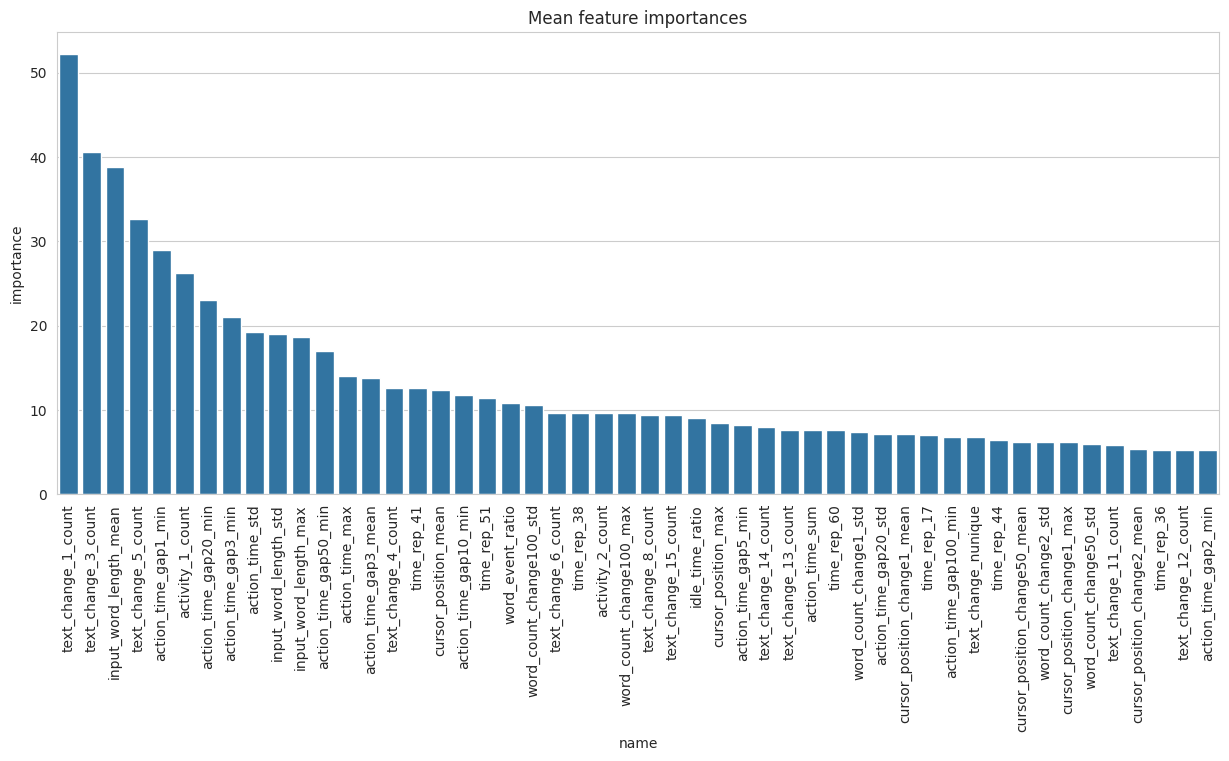

In [62]:
plt.figure(figsize=(15, 6))

ax = sns.barplot(data=feature_importance_df, x="name", y="importance")
ax.set_title(f"Mean feature importances")
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)

plt.show()

# Evaluation of OOF Preds on Training Set (CV)

In [63]:
for fold in range(CONFIG.num_folds):
    print(f"Predicting the train set with FOLD {fold}")
    X_train = train_feats_df[train_feats_df["fold"] != fold][feature_names]
    Y_train = train_feats_df[train_feats_df["fold"] != fold][CONFIG.response_variate]

    X_val = train_feats_df[train_feats_df["fold"] == fold][feature_names]
    Y_val = train_feats_df[train_feats_df["fold"] == fold][CONFIG.response_variate]

    lgb_model = models_dict[fold]
    pred_val = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration_)
    train_feats_df.loc[X_val.index, f"pred_{CONFIG.response_variate}"] = pred_val

Predicting the train set with FOLD 0
Predicting the train set with FOLD 1
Predicting the train set with FOLD 2
Predicting the train set with FOLD 3
Predicting the train set with FOLD 4


In [64]:
rmse = mean_squared_error(
    train_feats_df[CONFIG.response_variate],
    np.clip(train_feats_df[f"pred_{CONFIG.response_variate}"], a_min=0.5, a_max=6.0),
    squared=False,
)
print("CV RMSE:", rmse)

CV RMSE: 0.6480191907440073


# Predicting The Test Set

We use the mean of all the predictions for all the fold models

In [65]:
test_feats_df = test_feats.merge(representation_df_test, on="id")

In [66]:
for fold in range(CONFIG.num_folds):
    print(f"Predicting the test set with FOLD {fold}")
    X_test = test_feats_df[feature_names]

    lgb_model = models_dict[fold]
    pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration_)
    test_feats_df[f"pred_{CONFIG.response_variate}_fold{fold}"] = pred

test_feats_df[CONFIG.response_variate] = test_feats_df[
    [f"pred_{CONFIG.response_variate}_fold{fold}" for fold in range(CONFIG.num_folds)]
].mean(axis=1)
test_feats_df[CONFIG.response_variate] = np.clip(
    test_feats_df[CONFIG.response_variate], a_min=0.5, a_max=6.0
)

Predicting the test set with FOLD 0
Predicting the test set with FOLD 1
Predicting the test set with FOLD 2
Predicting the test set with FOLD 3
Predicting the test set with FOLD 4


# Submission

In [67]:
submission = test_feats_df[["id", CONFIG.response_variate]]
submission

,id,score
0,0000aaaa,1.231574
1,2222bbbb,1.159382
2,4444cccc,1.162360


In [68]:
submission.to_csv("submission.csv", index=False)

# Thanks for reading!